In [131]:
import numpy as np
from tqdm import tqdm, trange
import pylab as pl
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

# Heler Functions

In [132]:
def binary2index(var):
    if var.ndim == 1:
        return np.sum(np.power(2, np.arange(len(var))) * var).astype(int)
    elif var.ndim == 2:
        return np.sum(
            np.power(2, np.arange(var.shape[0]))[:, np.newaxis] * var, axis=0
        ).astype(int)
    else:
        print("why more than 2 dimensions?")


def index2binary(var, n_all_agents):
    if np.isscalar(var):
        return (var & (1 << np.arange(n_all_agents))) > 0
    elif var.ndim == 1:
        return (var[np.newaxis, :] & (1 << np.arange(n_all_agents)[:, np.newaxis])) > 0
    else:
        print("why more than 1 dimensions?")

# Bit Flip Env

In [133]:
class BF:
    def __init__(self, n_actions, n_teams, team_size, policy_seed, avg_pairwise_correlation = 0.5, method="sum"):
        self.nA = n_actions
        self.n_teams = n_teams
        self.team_size = team_size
        self.all_agents = n_teams * team_size + 1
        self.all_other_agents = self.all_agents - 1
        self.nS = self.nA ** (self.all_agents)
        self.policy_seed = policy_seed
        self.corr = avg_pairwise_correlation
        self.method = method
        self.policies = None
        self.rng = np.random.default_rng(self.policy_seed)
        self.agent_1_policy = self.rng.integers(0, 2, 2 ** (self.all_agents), dtype=bool)
        self.get_other_agent_policies(gen_type=self.method)

    def get_other_agent_policies(
        self,
        gen_type="sum",
        ):
        self.policies = np.zeros(self.nS, dtype=int)

        rng = np.random.default_rng(self.policy_seed)
        agent_indices_bool = np.zeros(self.all_other_agents, dtype=bool)

        rho_normaldist = np.sin(np.pi / 2 * self.corr)
        batch_size = np.min((int(2 ** 25), self.nS))
        tmp_policies = np.zeros((self.all_other_agents, batch_size), dtype=bool)
        for batch_idx in range(int(self.nS / batch_size)):
            for team in range(n_teams):
                agent_indices = range(team * self.team_size, (team + 1) * self.team_size)
                agent_indices_bool[agent_indices] = True

                if (
                    gen_type == "mix"
                ):  # Bernoulli mixture of independent and identical binary RVs
                    is_same = self.corr > self.rng.random(batch_size)
                    n_same = np.sum(is_same)
                    n_diff = batch_size - n_same
                    tmp_policies[np.ix_(agent_indices_bool, is_same)] = self.rng.integers(
                        0, 2, n_same
                    )[np.newaxis, :]
                    tmp_policies[np.ix_(agent_indices_bool, ~is_same)] = self.rng.integers(
                        0, 2, [self.team_size, n_diff]
                    )
                elif (
                    gen_type == "sum"
                ):  # signed sum of independent and identical normal RVs
                    tmp_policies[agent_indices_bool, :] = (
                        np.sqrt(1 - rho_normaldist)
                        * rng.normal(size=(self.team_size, batch_size))
                        + np.sqrt(rho_normaldist)
                        * rng.normal(size=batch_size)[np.newaxis, :]
                    ) > 0
                else:
                    print("choose sum or mix")

                agent_indices_bool[agent_indices] = False
            self.policies[
                batch_idx * batch_size: (batch_idx + 1) * batch_size
            ] = binary2index(
                np.vstack(
                    (
                        self.agent_1_policy[
                            batch_idx * batch_size: (batch_idx + 1) * batch_size
                        ],
                        tmp_policies,
                    )
                )
            )

    def get_reward(self, agent_index, state):
        fraction = state.sum()/len(state)
        reward = 1.0 / (fraction*int(state[agent_index]) + (1-fraction)*int(1-state[agent_index]))
        return reward

    def P(self, s, a):
        next_state = self.policies[s]
        next_state = index2binary(next_state, self.all_agents)
        next_state[0] = a
        prob = 1.0 # transitions are deterministic
        reward = self.get_reward(agent_index=0, state=next_state) # get reward for agent 0
        return prob, next_state, reward

    def reset(self, seed=0):
        # return state 0 by deafult
        self.state = 0
        return self.state

# Value Iteration

In [139]:
def value_iteration(env, theta=0.0001, discount_factor=1.0, max_iterations=100000):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    V_history = []

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward in [env.P(state, a)]:
                next_state = binary2index(next_state)
                # print("next state index is ", next_state)
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    time_step = 0
    
    while True:
        # Stopping condition
        time_step += 1
        delta = 0

        # Update each state...
        # TODO: randmized order
        r_list = np.arange(env.nS)
        np.random.shuffle(r_list)
        for s in r_list:
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value  

        # save sweep 
        V_history.append(np.mean(V))
        # Check if we can stop 
        if delta < theta:
            print("converged", time_step)
            break
        if time_step >= max_iterations:
            print("max iterations reached", time_step)
            break

        if time_step % 100 == 0:
            print("time step ", time_step)
            # print(V[:10])

    # Create a deterministic policy using the optimal value function
    policy = np.zeros(env.nS, dtype='int')
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        # A[0] corresponds to action 0 and A[1] corresponds to action 1, therefore instead of the one-hot value we use the index of the best action
        policy[s] = best_action
    
    return policy, V, V_history

# Run Sims

In [140]:
np.random.seed(0)
seed_list = np.random.randint(0, 2**32, size=10)

In [141]:
seed_list

array([2357136044, 2546248239, 3071714933, 3626093760, 2588848963,
       3684848379, 2340255427, 3638918503, 1819583497, 2678185683])

In [142]:
result_dict = {}

In [159]:
for team_size, n_teams in [(5,1), (10,1),(15,1), (20,1)]:
    result_dict[(team_size, n_teams)] = {}
    for rho in [0.0, 0.5, 1.0]:
        result_dict[(team_size, n_teams)][rho] = {}
        for seed in seed_list:
            print("team size ", team_size, " n_teams ", n_teams, " rho ", rho, " seed ", seed)
            result_dict[(team_size, n_teams)][rho][seed] = {}
            env_sum = BF(n_actions=2, n_teams=n_teams, team_size=team_size, avg_pairwise_correlation=rho, policy_seed=seed, method="sum")
            env_mix = BF(n_actions=2, n_teams=n_teams, team_size=team_size, avg_pairwise_correlation=rho, policy_seed=seed, method="mix")
            policy_sum, V_sum, V_sum_hist = value_iteration(env_sum, discount_factor=0.99, max_iterations=10000)
            result_dict[(team_size, n_teams)][rho][seed]["sum"] = [policy_sum, V_sum, V_sum_hist]
            policy_mix, V_mix, V_mix_hist = value_iteration(env_mix, discount_factor=0.99, max_iterations=10000)
            result_dict[(team_size, n_teams)][rho][seed]["mix"] = [policy_mix, V_mix, V_mix_hist]

team size  5  n_teams  1  rho  0.0  seed  2357136044
time step  100
time step  200
time step  300
time step  400
time step  500
time step  600
converged 662
time step  100
time step  200
time step  300
time step  400
time step  500
time step  600
time step  700
time step  800
time step  900
time step  1000
time step  1100
converged 1166
team size  5  n_teams  1  rho  0.0  seed  2546248239
time step  100
time step  200
time step  300
time step  400
time step  500
time step  600
converged 652
time step  100
time step  200
time step  300
time step  400
time step  500
time step  600
time step  700
time step  800
time step  900
time step  1000
converged 1097
team size  5  n_teams  1  rho  0.0  seed  3071714933
time step  100
time step  200
time step  300
time step  400
time step  500
time step  600
converged 673
time step  100
time step  200
time step  300
time step  400
time step  500
time step  600
converged 686
team size  5  n_teams  1  rho  0.0  seed  3626093760
time step  100
time step

# Save and Load Data

In [144]:
with open('result_rand.p', 'wb') as fp:
    pickle.dump(result_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [145]:
# with open('result.p', 'rb') as fp:
#     result_dict = pickle.load(fp)

In [146]:
rows = []
columns = set()
data_sum = []
data_mix = []

for i, pair in enumerate(result_dict):
    for j, rho in enumerate(result_dict[pair]):
        rows.append(pair + (rho,))
        for seed in result_dict[pair][rho]:
            columns.add((seed,))
            n_all_agents = pair[0] * pair[1] + 1
            a = np.arange(0, 2**(n_all_agents))
            b = index2binary(a, n_all_agents)
            optimal_p = (b.sum(axis=0) < n_all_agents/2)
            learned_p_mix= np.array(result_dict[pair][rho][seed]["mix"][0], dtype=bool)
            learned_p_sum = np.array(result_dict[pair][rho][seed]["sum"][0], dtype=bool)

            data_sum.append(np.mean(learned_p_sum == optimal_p))
            data_mix.append(np.mean(learned_p_mix == optimal_p))


In [147]:
columns = np.array([i for (i,) in columns])

In [148]:
rows = np.array(rows)
columns = np.array(columns)
data_sum = np.array(data_sum).reshape(rows.shape[0], columns.shape[0])
data_mix = np.array(data_mix).reshape(rows.shape[0], columns.shape[0])

/Users/ens/miniforge3/envs/marl/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


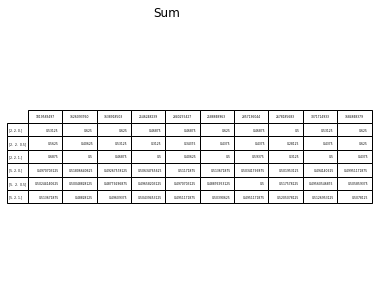

In [149]:
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=data_sum,
        rowLabels=rows,
        colLabels=columns,
        loc='center')

fig.suptitle("Sum")
fig.tight_layout()
fig.savefig("table_sum.pdf")

/Users/ens/miniforge3/envs/marl/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


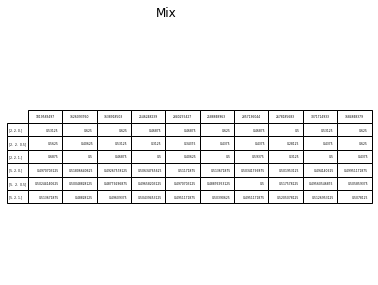

In [150]:
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=data_sum,
        rowLabels=rows,
        colLabels=columns,
        loc='center')

fig.suptitle("Mix")
fig.tight_layout()
fig.savefig("table_mix.pdf")

# Plotting

In [151]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'mix')

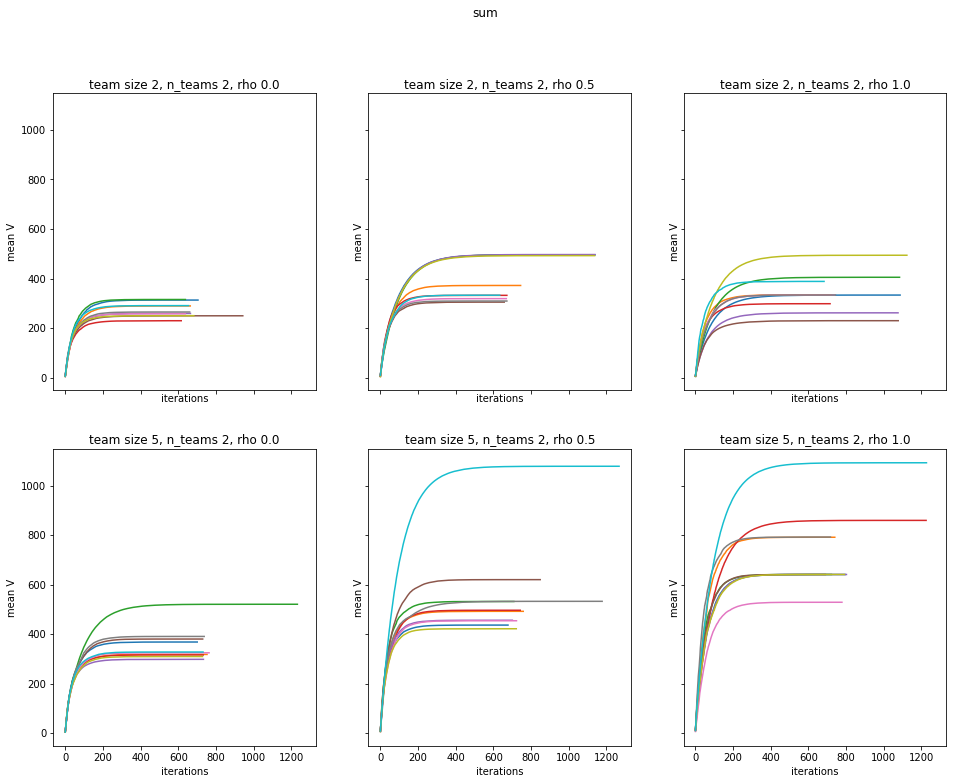

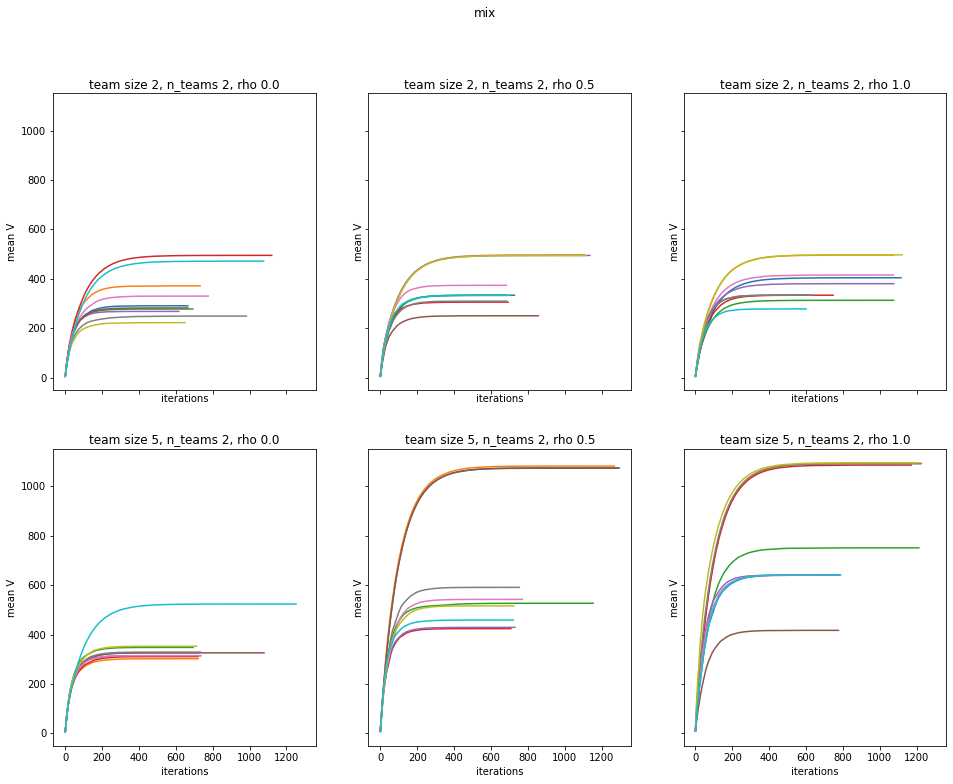

In [152]:
fig_sum, ax_sum = plt.subplots(2, 3, figsize=(16, 12), sharex=True, sharey=True)
fig_mix, ax_mix = plt.subplots(2, 3, figsize=(16, 12), sharex=True, sharey=True)

for i, pair in enumerate(result_dict):
    for j, rho in enumerate(result_dict[pair]):
        ax_sum[i][j].set_title("team size {}, n_teams {}, rho {}".format(pair[0], pair[1], rho))
        ax_sum[i][j].set_xlabel("iterations")
        ax_sum[i][j].set_ylabel("mean V")

        ax_mix[i][j].set_title("team size {}, n_teams {}, rho {}".format(pair[0], pair[1], rho))
        ax_mix[i][j].set_xlabel("iterations")
        ax_mix[i][j].set_ylabel("mean V")

        for seed in result_dict[pair][rho]:
            ax_sum[i][j].plot(result_dict[pair][rho][seed]["sum"][2], label="f{}".format(seed))
            ax_mix[i][j].plot(result_dict[pair][rho][seed]["mix"][2], label="f{}".format(seed))
            
            # ax_sum[i][j].legend()
            # ax_mix[i][j].legend()
fig_sum.suptitle("sum")
fig_mix.suptitle("mix")

In [153]:
fig_sum.tight_layout()
fig_sum.savefig("fig_sum.pdf")
fig_sum.show()

/var/folders/27/bskdj9jn79lclxwd3s0t9bxw0000gn/T/ipykernel_23048/1406186232.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_sum.show()


In [154]:
fig_mix.tight_layout()
fig_mix.savefig("fig_mix.pdf")
fig_mix.show()

/var/folders/27/bskdj9jn79lclxwd3s0t9bxw0000gn/T/ipykernel_23048/2808991900.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_mix.show()


In [155]:
import matplotlib.patches as mpatches

Text(0.5, 0.98, 'mix')

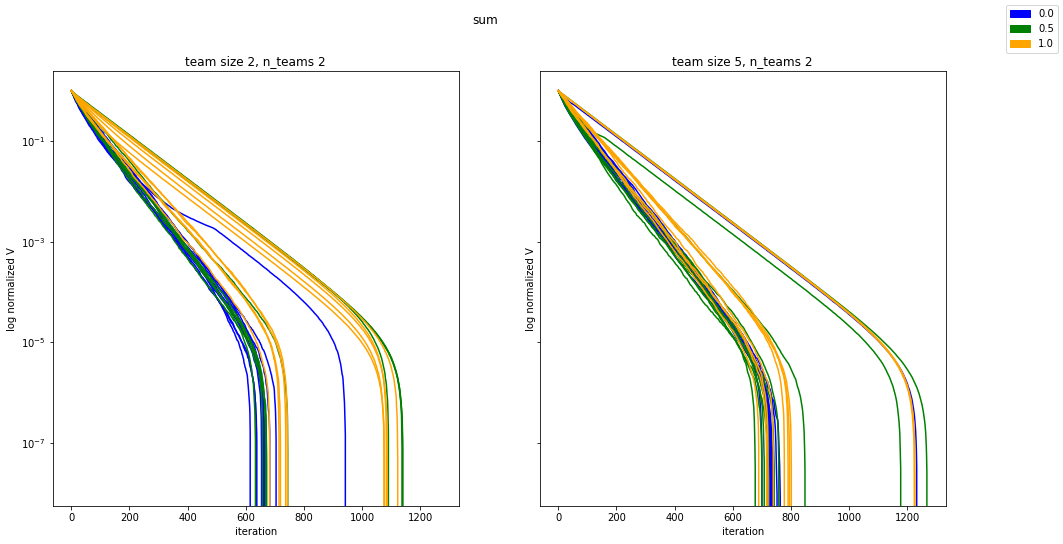

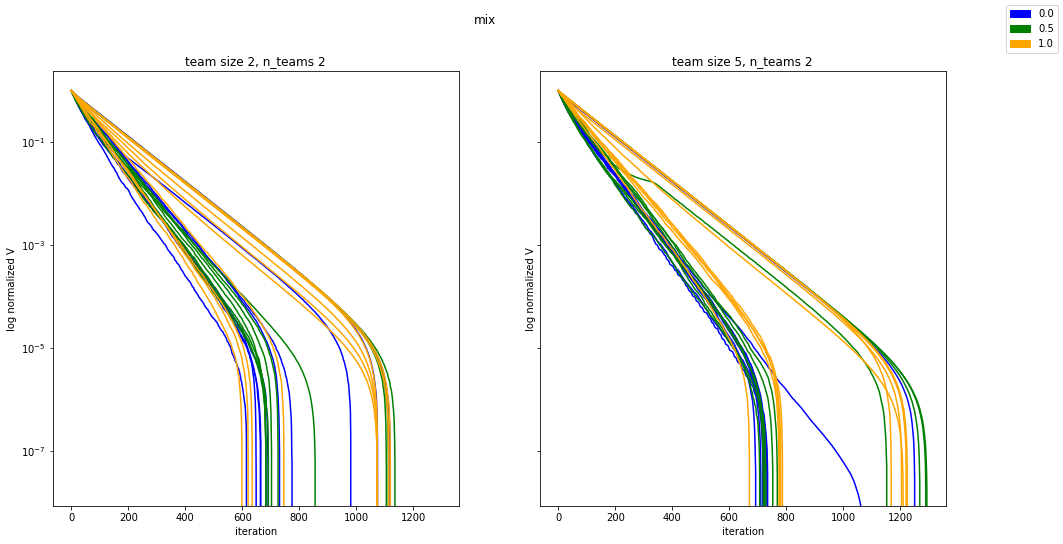

In [156]:
fig_sum, ax_sum = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
fig_mix, ax_mix = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
colors = ["blue", "green", "orange", "purple", "black"]
blue_patch = mpatches.Patch(color='blue', label='The blue data')
green_patch = mpatches.Patch(color='green', label='The green data')
orange_patch = mpatches.Patch(color='orange', label='The orange data')

rho_list = result_dict[pair].keys()

for i, pair in enumerate(result_dict):
    ax_sum[i].set_title("team size {}, n_teams {}".format(pair[0], pair[1]))
    ax_sum[i].set_xlabel("iteration")
    ax_sum[i].set_ylabel("log normalized V")
    ax_mix[i].set_title("team size {}, n_teams {}".format(pair[0], pair[1]))
    ax_mix[i].set_xlabel("iteration")
    ax_mix[i].set_ylabel("log normalized V")
    
    for j, rho in enumerate(result_dict[pair]):
        for seed in result_dict[pair][rho]:
            V_mix_hist = result_dict[pair][rho][seed]["sum"][2]
            V_sum_hist = result_dict[pair][rho][seed]["mix"][2]

            normalized_V_mix_hist = [abs(V_mix_hist[i]-V_mix_hist[-1])/(V_mix_hist[-1] - V_mix_hist[0]) for i in range(len(V_mix_hist))]
            normalized_V_sum_hist = [abs(V_sum_hist[i]-V_sum_hist[-1])/(V_sum_hist[-1] - V_sum_hist[0]) for i in range(len(V_sum_hist))]

            line_sum = ax_sum[i].plot(normalized_V_mix_hist, color=colors[j])
            line_mix = ax_mix[i].plot(normalized_V_sum_hist, color=colors[j])
            
    ax_sum[i].set_yscale('log')
    ax_mix[i].set_yscale('log')

fig_sum.legend([blue_patch, green_patch, orange_patch], rho_list)
fig_mix.legend([blue_patch, green_patch, orange_patch], rho_list)
fig_sum.suptitle("sum")
fig_mix.suptitle("mix")

In [157]:
fig_sum.tight_layout()
fig_sum.savefig("fig_time_sum.pdf")
fig_sum.show()

/var/folders/27/bskdj9jn79lclxwd3s0t9bxw0000gn/T/ipykernel_23048/2050371047.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_sum.show()


In [158]:
fig_mix.tight_layout()
fig_mix.savefig("fig_time_mix.pdf")
fig_mix.show()

/var/folders/27/bskdj9jn79lclxwd3s0t9bxw0000gn/T/ipykernel_23048/3618467200.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_mix.show()


# Junk

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12), sharex=True, sharey=True)

for i, pair in enumerate(result_dict):
    for j, rho in enumerate(result_dict[pair]):
        ax[i][j].set_title("team size {}, n_teams {}, rho {}".format(pair[0], pair[1], rho))
        ax[i][j].set_xlabel("seed")
        ax[i][j].set_ylabel("log of normalized timescale")

        timescales = []
        for seed in result_dict[pair][rho]:
            timescales.append(len(result_dict[pair][rho][seed]["het"][2]))
            # ax[i][j].plot(result_dict[pair][rho][seed]["het"][2], label="f{}".format(seed))
            # ax_het[i][j].plot(result_dict[pair][rho][seed]["het"][2], label="f{}".format(seed))
            # ax[i][j].legend()
            # ax_het[i][j].legend()
        timescales.sort()
        normalized_timescales = [(t-timescales[0])/(timescales[-1] - timescales[0]) for t in timescales]
        log_norm_t = [np.log(t) for t in normalized_timescales]
        # print(timescales)
        print(normalized_timescales)
        ax[i][j].plot(log_norm_t)


# fig.suptitle("homogeneous")
# fig_het.suptitle("heterogeneous")

# Bit Flip Environment (Old One)

In [ ]:
class MABitFlipEnv:

    def __init__(self, n_actions, n_agents, n_memory, n_teams, avg_pairwise_correlation = 0.5, is_het=False):
        self.nA = n_actions
        self.n_agents = n_agents
        self.n_memory = n_memory
        self.nS = self.nA ** (self.n_agents * self.n_memory)
        self.nS_plus = self.nA * self.nS
        self.state = None
        self.n_teams = n_teams
        self.is_het = is_het
        self.avg_pairwise_correlation = avg_pairwise_correlation
        self.policies = np.zeros((self.n_agents, self.nS),dtype=bool)
        self.joint_action_seqs = []
        self.calculate_policies()

    def get_hom_policies(self):
        team_size = int(self.n_agents/self.n_teams)
        rng = np.random.default_rng(12345)
        agent_indices_bool = np.zeros(self.n_agents,dtype=bool)
        for team in range(self.n_teams):
            agent_indices = range(team * team_size, (team+1) * team_size)
            agent_indices_bool[agent_indices]=True
            #joint actions for a group are assigned Bernoulli: {as same over the group, else random}
            is_same = (self.avg_pairwise_correlation > rng.random(self.nS)) #TODO: add more than binary ations is_same=(avg_pairwise_correlation>np.random.rand(0, n_actions, n_states)) #joint actions for a group are assigned as same over the group, else random
            n_same = np.sum(is_same)
            n_diff = self.nS-n_same
            self.policies[np.ix_(agent_indices_bool, is_same)] = np.random.randint(0, self.nA, n_same)[np.newaxis,:]
            self.policies[np.ix_(agent_indices_bool, ~is_same)] = np.random.randint(0, self.nA, [team_size,n_diff])
            agent_indices_bool[agent_indices] = False #reset

    def get_het_policies(self):
        team_size = int(self.n_agents/self.n_teams)
        rng = np.random.default_rng(12345)
        agent_indices_bool = np.zeros(self.n_agents, dtype=bool)
        rho=np.sin(np.pi/2*self.avg_pairwise_correlation)
        for team in range(self.n_teams):
            agent_indices = range(team * team_size, (team+1) * team_size)
            agent_indices_bool[agent_indices]=True
            self.policies[agent_indices_bool, :] = ((np.sqrt(1 - rho)*rng.normal(size = (team_size, self.nS)) + np.sqrt(rho)*rng.normal(size = self.nS)[np.newaxis,:]) > 0)
            agent_indices_bool[agent_indices] = False

    def calculate_policies(self):
        if self.is_het:
            self.get_het_policies()
        else:
            self.get_hom_policies()

    def get_reward(self, agent_index, s_plus):
        fraction = s_plus.sum()/len(s_plus)
        reward = 1.0 / (fraction*int(s_plus[agent_index]) + (1-fraction)*int(1-s_plus[agent_index]))
        return reward

    def P(self, s, a):
        next_state = self.policies[:, s]
        next_s_plus = np.insert(next_state, 0, a)
        prob = 1.0 # transitions are deterministic
        reward = self.get_reward(0, next_s_plus) # get reward for agent 0
        return prob, next_s_plus, reward
    
    def step(self, a):
        next_state = self.policies[:, self.state]
        self.state = binary2index(next_state)
        next_s_plus = np.insert(next_state, 0, a)
        reward = self.get_reward(0, next_s_plus)
        return next_s_plus, reward

    def reset(self, seed=0):
        # return state 0 by deafult
        self.state = 0
        return self.state